<a href="https://colab.research.google.com/github/k2herat/dm_project/blob/First_part/first_part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем библиотеки


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace, skewnorm
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
import networkx as nx
from tqdm import tqdm


Задаём параметры

In [32]:
BETA_0 = np.sqrt(0.5)
ALPHA_0 = 1.0

KNN

In [33]:
def build_knn_graph(data, k):
    graph = kneighbors_graph(data.reshape(-1, 1), k, mode='connectivity')
    return nx.from_scipy_sparse_array(graph)



def compute_t_knn(graph):
    degrees = dict(graph.degree())
    return np.mean(list(degrees.values()))



Построение дистанционного графа

In [34]:
def build_dist_graph(data, radius):
    graph = radius_neighbors_graph(data.reshape(-1, 1), radius, mode='connectivity')
    return nx.from_scipy_sparse_array(graph)

def compute_t_dist(graph):
    return nx.average_shortest_path_length(graph) if nx.is_connected(graph) else np.nan

Генерация данных

In [35]:
def generate_laplace_sample(n, beta=1.0):
    return laplace(loc=0, scale=beta).rvs(n)

def generate_skewnorm_sample(n, alpha=1.0):
    return skewnorm(a=alpha).rvs(n)

# **Анализ**

Исследование SkewNorm: 100%|██████████| 20/20 [09:53<00:00, 29.68s/it]


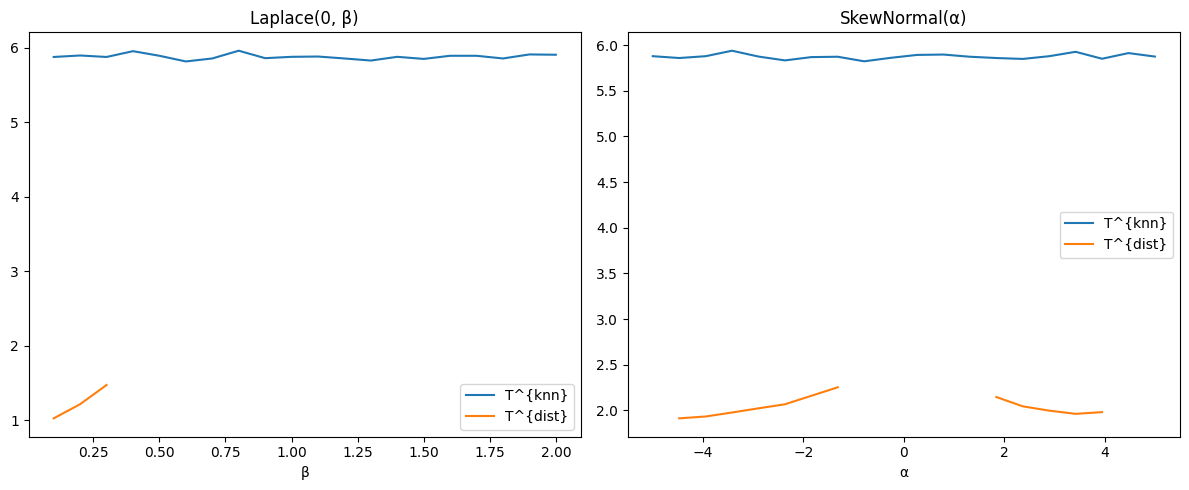

In [36]:
n = 1000
k = 5
radius = 0.5

beta_values = np.linspace(0.1, 2.0, 20)
t_knn_laplace = []
t_dist_laplace = []

for beta in tqdm(beta_values, desc="Исследование Laplace"):
    data = generate_laplace_sample(n, beta)
    graph_knn = build_knn_graph(data, k)
    graph_dist = build_dist_graph(data, radius)
    t_knn_laplace.append(compute_t_knn(graph_knn))
    t_dist_laplace.append(compute_t_dist(graph_dist))

alpha_values = np.linspace(-5, 5, 20)
t_knn_skew = []
t_dist_skew = []

for alpha in tqdm(alpha_values, desc="Исследование SkewNorm"):
    data = generate_skewnorm_sample(n, alpha)
    graph_knn = build_knn_graph(data, k)
    graph_dist = build_dist_graph(data, radius)
    t_knn_skew.append(compute_t_knn(graph_knn))
    t_dist_skew.append(compute_t_dist(graph_dist))

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(beta_values, t_knn_laplace, label='T^{knn}')
plt.plot(beta_values, t_dist_laplace, label='T^{dist}')
plt.title('Laplace(0, β)')
plt.xlabel('β')
plt.legend()

plt.subplot(122)
plt.plot(alpha_values, t_knn_skew, label='T^{knn}')
plt.plot(alpha_values, t_dist_skew, label='T^{dist}')
plt.title('SkewNormal(α)')
plt.xlabel('α')
plt.legend()
plt.tight_layout()
plt.show()


**Исследование зависимости от параметров графа и n**

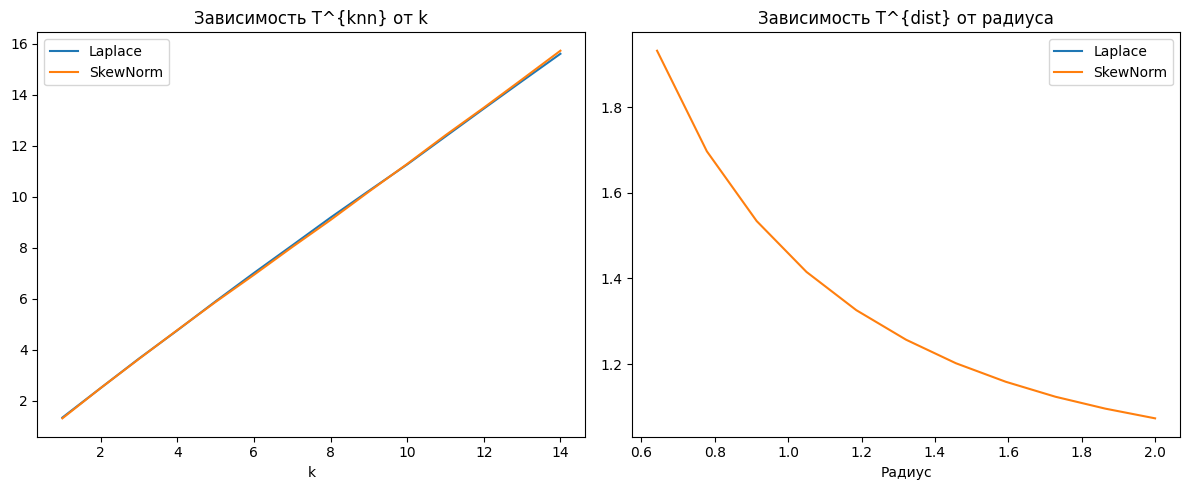

In [37]:
beta0 = np.sqrt(0.5)
alpha0 = 1.0

k_values = np.arange(1, 15)
radius_values = np.linspace(0.1, 2.0, 15)

data_laplace = generate_laplace_sample(n, beta0)
t_knn_var_k_laplace = [compute_t_knn(build_knn_graph(data_laplace, k)) for k in k_values]
t_dist_var_radius_laplace = [compute_t_dist(build_dist_graph(data_laplace, r)) for r in radius_values]

data_skew = generate_skewnorm_sample(n, alpha0)
t_knn_var_k_skew = [compute_t_knn(build_knn_graph(data_skew, k)) for k in k_values]
t_dist_var_radius_skew = [compute_t_dist(build_dist_graph(data_skew, r)) for r in radius_values]

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(k_values, t_knn_var_k_laplace, label='Laplace')
plt.plot(k_values, t_knn_var_k_skew, label='SkewNorm')
plt.title('Зависимость T^{knn} от k')
plt.xlabel('k')
plt.legend()

plt.subplot(122)
plt.plot(radius_values, t_dist_var_radius_laplace, label='Laplace')
plt.plot(radius_values, t_dist_var_radius_skew, label='SkewNorm')
plt.title('Зависимость T^{dist} от радиуса')
plt.xlabel('Радиус')
plt.legend()
plt.tight_layout()
plt.show()

Оценка мощности

In [38]:
alpha = 0.05**5
n_trials = 200

t0_knn_laplace = [compute_t_knn(build_knn_graph(generate_laplace_sample(n, beta0), k)) for _ in tqdm(range(n_trials))]
t0_knn_skew = [compute_t_knn(build_knn_graph(generate_skewnorm_sample(n, alpha0), k)) for _ in tqdm(range(n_trials))]

crit_low_laplace = np.quantile(t0_knn_laplace, alpha/2)
crit_high_laplace = np.quantile(t0_knn_laplace, 1 - alpha/2)

t_alt_laplace = [compute_t_knn(build_knn_graph(generate_laplace_sample(n, 2*beta0), k)) for _ in tqdm(range(n_trials))]
power_laplace = np.mean((np.array(t_alt_laplace) < crit_low_laplace) | (np.array(t_alt_laplace) > crit_high_laplace))

print(f"Критическая область для Laplace: ({crit_low_laplace:.3f}, {crit_high_laplace:.3f})")
print(f"Мощность критерия для Laplace: {power_laplace:.3f}")

crit_low_skew = np.quantile(t0_knn_skew, alpha/2)
crit_high_skew = np.quantile(t0_knn_skew, 1 - alpha/2)
t_alt_skew = [compute_t_knn(build_knn_graph(generate_skewnorm_sample(n, 2.0), k)) for _ in tqdm(range(n_trials))]
power_skew = np.mean((np.array(t_alt_skew) < crit_low_skew) | (np.array(t_alt_skew) > crit_high_skew))

print(f"\nКритическая область для SkewNormal: ({crit_low_skew:.3f}, {crit_high_skew:.3f})")
print(f"Мощность критерия для SkewNormal: {power_skew:.3f}")

100%|██████████| 200/200 [00:08<00:00, 22.98it/s]


Критическая область для Laplace: (5.796, 5.964)
Мощность критерия для Laplace: 0.025


100%|██████████| 200/200 [00:03<00:00, 58.86it/s]


Критическая область для SkewNormal: (5.796, 5.976)
Мощность критерия для SkewNormal: 0.020
